In [30]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt

In [31]:
spark = SparkSession.builder.getOrCreate()

In [32]:
msNPC = spark.read.option("inferSchema","true").csv("Query + Visualization/MsNPC.csv", header=True)
msPlayer = spark.read.option("inferSchema","true").csv("Query + Visualization/MsPlayer.csv", header=True)
msWeapon = spark.read.option("inferSchema","true").csv("Query + Visualization/MsWeapon.csv", header=True)
msWeaponType = spark.read.option("inferSchema","true").csv("Query + Visualization/MsWeaponType.csv", header=True)
transactionDetail = spark.read.option("inferSchema","true").csv("Query + Visualization/TransactionDetail.csv", header=True)
transactionHeader = spark.read.option("inferSchema","true").csv("Query + Visualization/TransactionHeader.csv", header=True)

In [33]:
msNPC.registerTempTable("MsNPC")
msPlayer.registerTempTable("MsPlayer")
msWeapon.registerTempTable("MsWeapon")
msWeaponType.registerTempTable("MsWeaponType")
transactionDetail.registerTempTable("TransactionDetail")
transactionHeader.registerTempTable("TransactionHeader")

In [58]:
res1 = spark.sql("""
    SELECT WeaponTypeName, SUM(WeaponPrice*Quantity) as WeaponCount
    FROM TransactionHeader th
    JOIN TransactionDetail td
    ON th.TransactionId = td.TransactionId
    JOIN MsWeapon w ON td.WeaponId = w.WeaponId
    JOIN MsWeaponType wt ON w.WeaponTypeId = wt.WeaponTypeId
    WHERE YEAR(TransactionDate) = 2019
    GROUP BY WeaponTypeName
    ORDER BY WeaponCount ASC
    
""")

In [59]:
res1 = res1.toPandas()

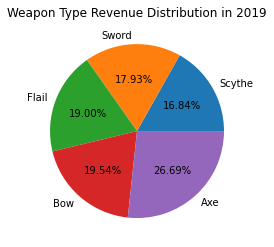

In [113]:
plt.title("Weapon Type Revenue Distribution in 2019")
plt.pie(res1["WeaponCount"],
       labels=res1["WeaponTypeName"],
       autopct="%.2f%%")
plt.show()

In [130]:
res2 = spark.sql("""
    SELECT COUNT(DISTINCT (th.PlayerId)) as PlayerCount, MONTH(TransactionDate) as Month
    FROM MsPlayer p JOIN TransactionHeader th
    ON p.PlayerId = th.PlayerId
    JOIN TransactionDetail td
    ON th.TransactionId = td.TransactionId
    JOIN MsWeapon w ON td.WeaponId = w.WeaponId
    JOIN MsWeaponType wt ON w.WeaponTypeId = wt.WeaponTypeId
    WHERE WeaponTypeName = 'Axe' AND YEAR(TransactionDate) = 2019
    GROUP BY Month
    ORDER BY Month
    
    
""")
res2 = res2.toPandas()

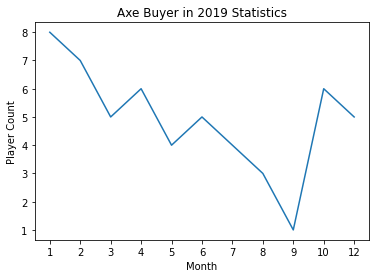

In [131]:
plt.plot(res2["PlayerCount"])
plt.xticks(range(len(res2["Month"])), res2["Month"])
plt.title("Axe Buyer in 2019 Statistics")
plt.xlabel("Month")
plt.ylabel("Player Count")
plt.show()

In [129]:
res3 = spark.sql("""
    

SELECT x.SpecialWeapon, COUNT(x.SpecialWeapon) as Frequency FROM
(
SELECT PlayerName,
CASE WHEN SUM(Quantity*WeaponPrice)>=1000000 AND SUM(Quantity*WeaponPrice)<=1499999 THEN 'Storm Breaker'
WHEN SUM(Quantity*WeaponPrice)>=1500000 AND SUM(Quantity*WeaponPrice)<=1999999 THEN 'Nightfall'
WHEN SUM(Quantity*WeaponPrice)>=2000000 THEN 'Extinction'
END AS SpecialWeapon
FROM MsPlayer p JOIN TransactionHeader th 
ON p.PlayerId = th.PlayerId
JOIN TransactionDetail td
ON th.TransactionId = td.TransactionId
JOIN MsWeapon w ON td.WeaponId = w.WeaponId
WHERE PlayerGender = 'Female' AND YEAR(TransactionDate) = 2019
GROUP BY PlayerName, MONTH(TransactionDate)
ORDER BY SUM(Quantity*WeaponPrice) DESC
) as x
GROUP BY x.SpecialWeapon



""")
res3 = res3.na.drop()
res3.show()
res3 = res3.toPandas()


+-------------+---------+
|SpecialWeapon|Frequency|
+-------------+---------+
|Storm Breaker|       17|
|   Extinction|        7|
|    Nightfall|        9|
+-------------+---------+



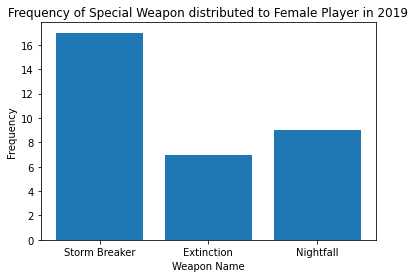

In [112]:
plt.bar(res3["SpecialWeapon"], res3["Frequency"])
plt.title("Frequency of Special Weapon distributed to Female Player in 2019")
plt.xlabel("Weapon Name")
plt.ylabel("Frequency")
plt.show()

In [170]:
res4 = spark.sql("""
SELECT x.Month, COUNT(x.PlayerId) as PlayerCount FROM
(
    SELECT th.PlayerId, MONTH(TransactionDate) as Month
    FROM MsPlayer p JOIN TransactionHeader th
    ON p.PlayerId = th.PlayerId
    JOIN TransactionDetail td
    ON th.TransactionId = td.TransactionId
    JOIN MsWeapon w
    ON td.WeaponId = w.WeaponId
    JOIN MsWeaponType wt 
    ON w.WeaponTypeId = wt.WeaponTypeId
    WHERE YEAR(TransactionDate) = 2019
    GROUP BY th.PlayerId, Month
    HAVING COUNT(DISTINCT(w.WeaponTypeId)) >=3
) as x
GROUP BY x.Month
ORDER BY x.Month



""")
res4 = res4.toPandas()
res4


,Month,PlayerCount
0,1,6
1,2,5
2,3,4
3,4,3
4,5,3
5,6,3
6,7,5
7,8,2
8,9,1
9,10,5


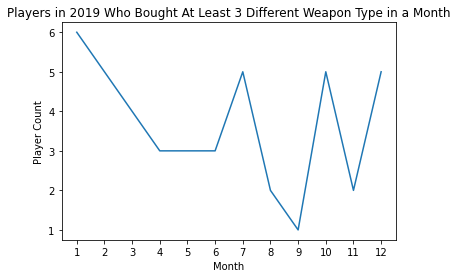

In [172]:
plt.plot(res4["PlayerCount"])
plt.xticks(range(len(res4["Month"])), res4["Month"])
plt.title("Players in 2019 Who Bought At Least 3 Different Weapon Type in a Month")
plt.xlabel("Month")
plt.ylabel("Player Count")
plt.show()

In [173]:
res5 = spark.sql ("""
    SELECT x.Popularity, COUNT(x.Popularity) as Frequency FROM
(
SELECT NPCName,
CASE WHEN SUM(Quantity*WeaponPrice)>=15000000 THEN 'Very Popular'
WHEN SUM(Quantity*WeaponPrice)>=7500000 AND SUM(Quantity*WeaponPrice)<=14999999 THEN 'Popular'
WHEN SUM(Quantity*WeaponPrice)>=2500000 AND SUM(Quantity*WeaponPrice)<=7499999 THEN 'Quite Popular'
WHEN SUM(Quantity*WeaponPrice)<2500000 THEN 'Not Popular'
END AS Popularity
FROM MsNPC  n JOIN TransactionHeader th
ON n.NPCId = th.NPCId
JOIN TransactionDetail td ON th.TransactionId = td.TransactionId
JOIN MsWeapon w ON td.WeaponId = w.WeaponId
JOIN MsWeaponType wt ON w.WeaponTypeId = wt.WeaponTypeId
GROUP BY NPCName
HAVING COUNT(DISTINCT (th.PlayerId)) >=5 AND COUNT(DISTINCT (th.TransactionId)) > 0
) as x
GROUP BY x.Popularity

""")
res5 = res5.toPandas()
res5

,Popularity,Frequency
0,Quite Popular,2
1,Popular,8
2,Very Popular,2


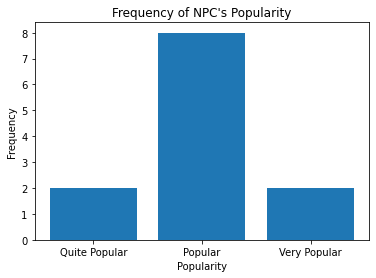

In [174]:
plt.bar(res5["Popularity"], res5["Frequency"])
plt.title("Frequency of NPC's Popularity")
plt.xlabel("Popularity")
plt.ylabel("Frequency")
plt.show()